# Proyecto Final Bioestadística

### Grupo 02
* Martín Cortés Albarracín - 202313528
* Hassan Eisa Cavieles Eljadue - 
* Sara Ximena Arias - 202


## Importamos librerías

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import pingouin as pg
from scipy import stats
import matplotlib.pyplot as plt
from __future__ import annotations   
from itertools import product  
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import bootstrap
from scipy.spatial import distance
from numpy.linalg import inv
from scipy.stats import chi2
from normalizato_utile import *

## Manejo que se hizo con el DataFrame original

* Se categorizó la variable MMSE de la siguiente manera:
    * 30-27 puntos: Sin deterioro
    * 26-25 puntos: Dudoso o posible deterioro
    * 24-10 puntos: Deterioro leve a moderado
    * 9-6 puntos: Demencia moderada a severa
    * Menos de 6 puntos: Demencia severa.
* Se categorizó la variable AGE en la siguiente manera:
    * 60-69 años
    * 70-79 años
    * 80-90 años


In [8]:
df = pd.read_csv("Dataset_G2.csv")
pos = 0
# Agrupamiento de edades
for data in df["Age"]:
    if data < 70:
        df["Age"][pos] = "60-69"
    elif data >= 70 and data < 80:
        df["Age"][pos] = "70-79"
    elif data >= 80 and data <= 90:
        df["Age"][pos] = "80-90"
    pos += 1
df["Age"] = df["Age"].astype("category")

# Agrupamiento de MMSE
pos = 0
for data in df["MMSE"]:
    if data >= 27:
        df["MMSE"][pos] = "Sin deterioro"
    elif data >= 25 and data < 27:
        df["MMSE"][pos] = "Posible deterioro"
    elif data >= 10 and data < 25:
        df["MMSE"][pos] = "Deterioro leve"
    elif data >= 6 and data < 10:
        df["MMSE"][pos] = "Deterioro moderado"
    elif data < 6:
        df["MMSE"][pos] = "Demencia severa"
    pos += 1
df["MMSE"] = df["MMSE"].astype("category")
print(df["Age"].value_counts())
print(df["MMSE"].value_counts())
#df.to_csv(Path("Datos_Proyecto_Final.csv", index=False))

C:\Users\user\AppData\Local\Temp\ipykernel_22840\3743001309.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["Age"][pos] = "70-79"
C:\Users\user\AppData\Local\Temp\ipykernel_22840\3743001309.py:8: SettingWithCopyWarning: 
A value is tr

Age
80-90    88980
70-79    81101
60-69    80856
Name: count, dtype: int64
MMSE
Deterioro leve        125082
Demencia severa        50317
Deterioro moderado     33688
Sin deterioro          25041
Posible deterioro      16809
Name: count, dtype: int64


## Carga de datos

In [18]:
df=pd.read_csv("Datos_G2.csv")
#df = df.dropna()
print(df["LocationDesc"].unique())
print(len(df))
columns_interes = ["Data_Value","Age","MMSE","ADL","CholesterolLDL","FunctionalAssessment"]

['West' 'Northeast' 'Midwest' 'Idaho' 'Louisiana' 'Massachusetts'
 'Maryland' 'New Mexico' 'Ohio' 'Oregon' 'South Carolina' 'South'
 'Wisconsin' 'Tennessee' 'New Hampshire' 'Kansas' 'Utah' 'Rhode Island'
 'Michigan' 'Washington' 'Virginia' 'Arizona' 'Mississippi' 'Montana'
 'West Virginia' 'Missouri' 'Vermont' 'Pennsylvania' 'North Carolina'
 'New Jersey' 'Arkansas' 'Hawaii' 'Connecticut' 'Minnesota' 'Texas'
 'Nebraska' 'New York' 'Maine' 'Alaska' 'Georgia' 'Indiana' 'Kentucky'
 'North Dakota' 'Oklahoma' 'Wyoming' 'District of Columbia' 'Iowa'
 'Alabama' 'South Dakota' 'Illinois' 'Colorado' 'Nevada' 'California'
 'Delaware']
2149


#### Histogramas

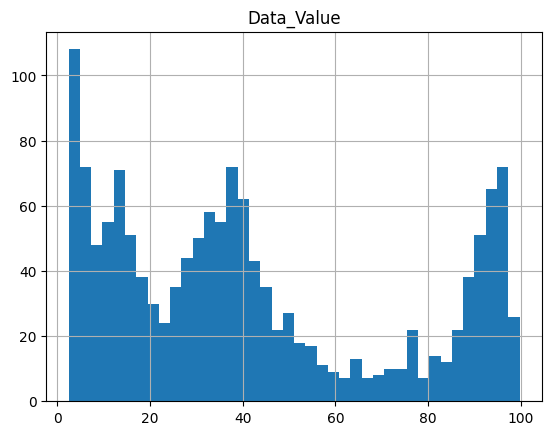

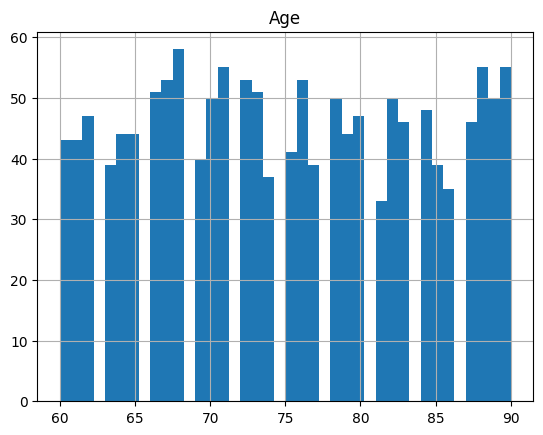

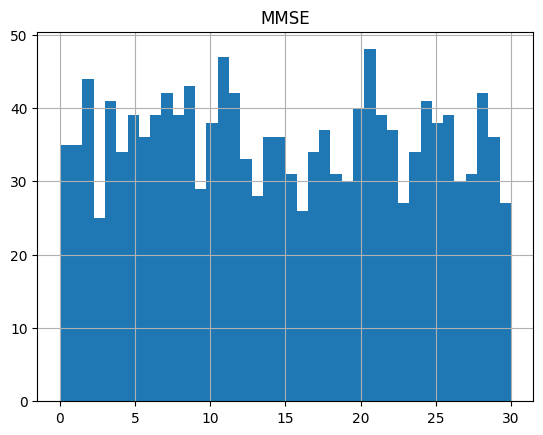

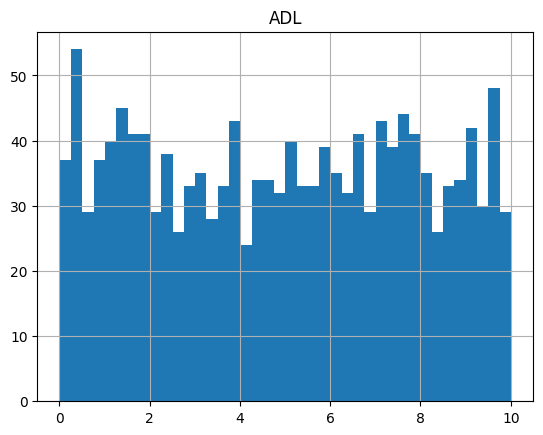

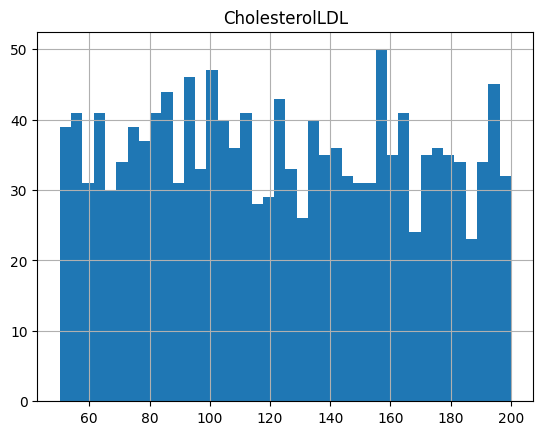

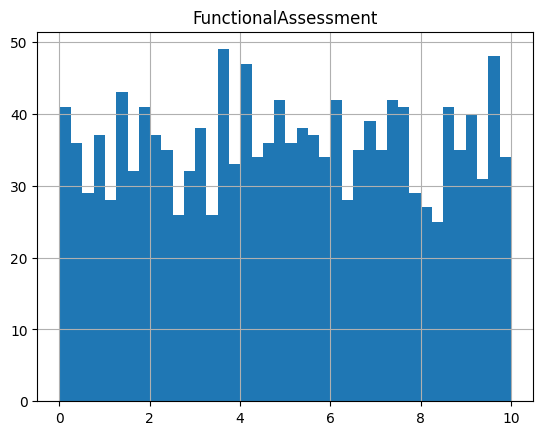

In [14]:
#[df[c].hist(bins=round(np.sqrt(len(df)))) for c in columns_interes]; plt.show()
for col in columns_interes:
  #df[col].hist(bins=round(np.sqrt(len(df)))); plt.title(col); plt.show()
  df[col].hist(bins=40); plt.title(col); plt.show()

#### Normalizado

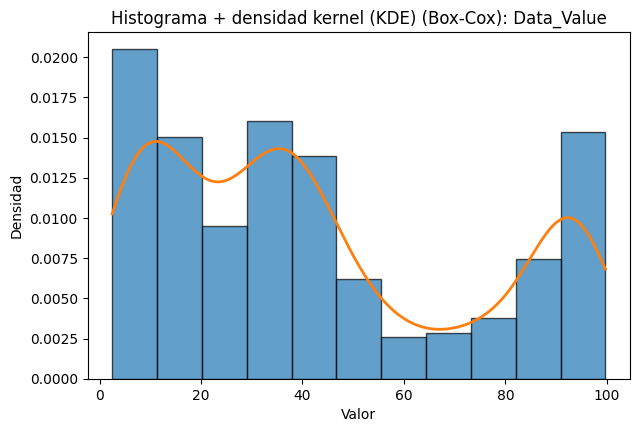

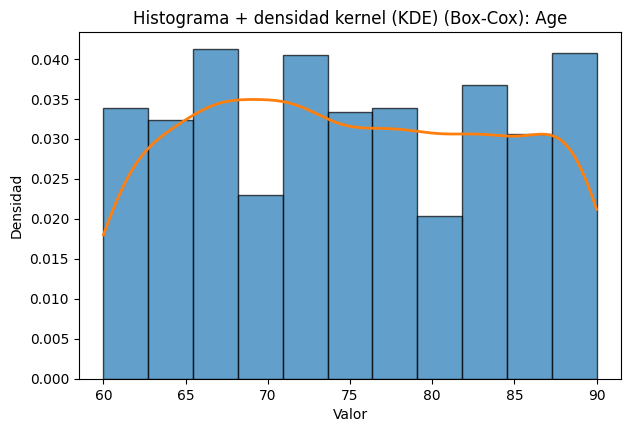

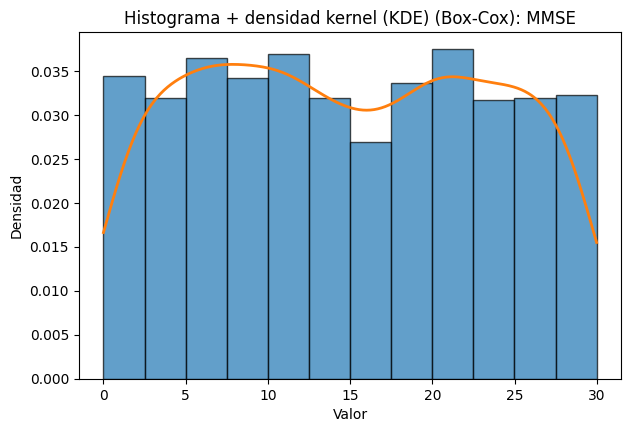

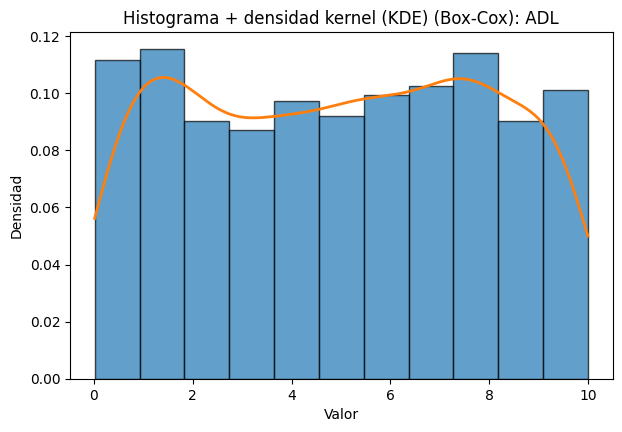

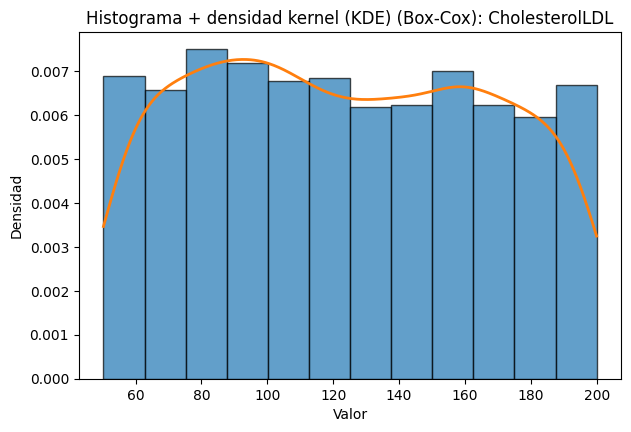

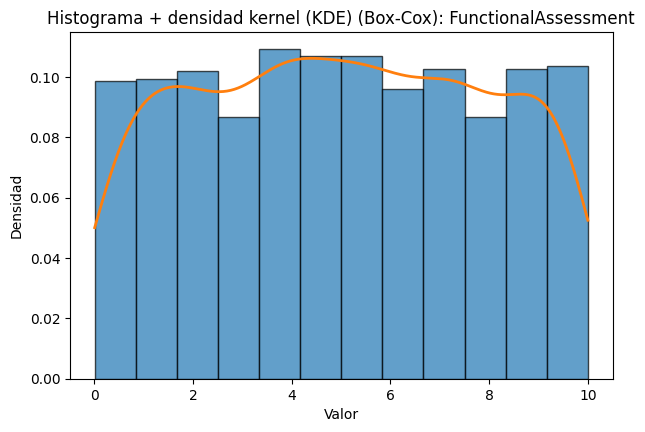

In [15]:
for col in columns_interes:
    columna = df[col].dropna()  # Remove NaNs
    plt.figure(figsize=(7,4.5))
    plt.hist(columna, bins="fd", density=True, alpha=0.7, edgecolor="black")
    kde = stats.gaussian_kde(columna)
    xs = np.linspace(columna.min(), columna.max(), 400)
    plt.plot(xs, kde(xs), linewidth=2)
    plt.title(f"Histograma + densidad kernel (KDE) (Box-Cox): {col}")
    plt.xlabel("Valor"); plt.ylabel("Densidad")
    plt.show()

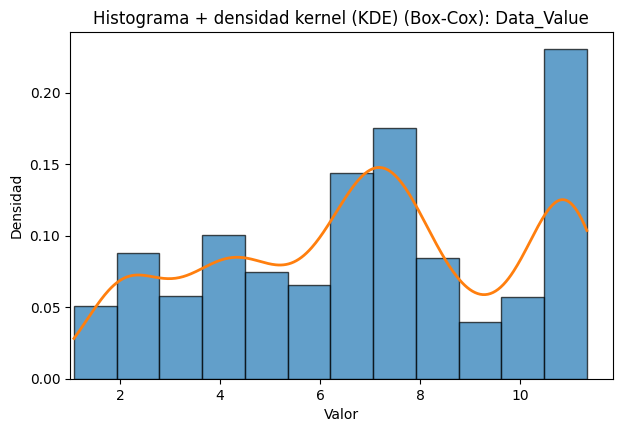

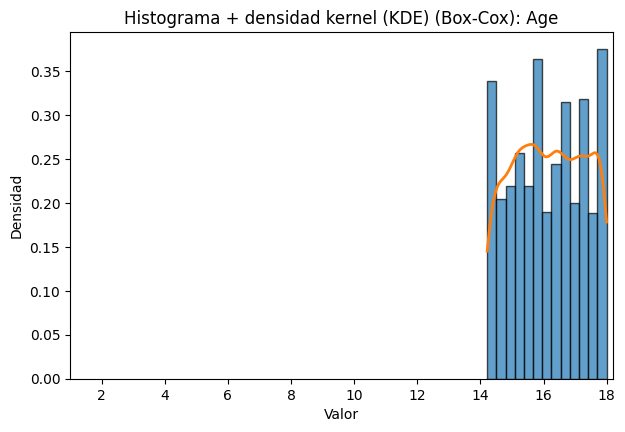

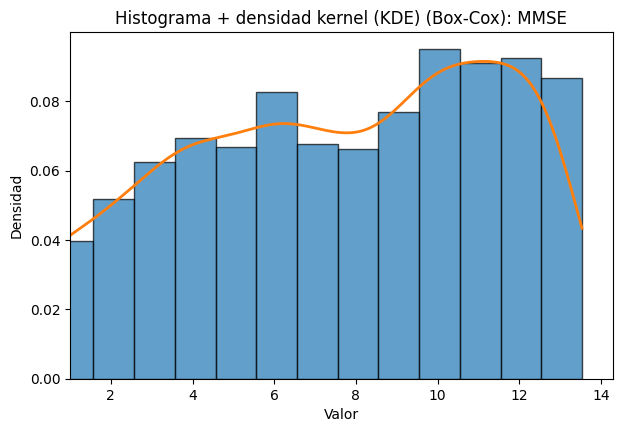

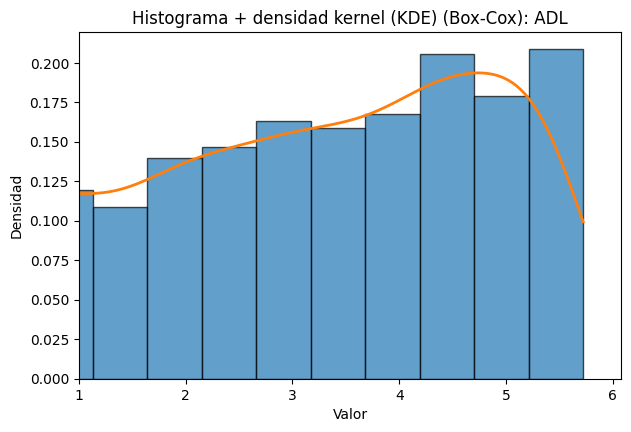

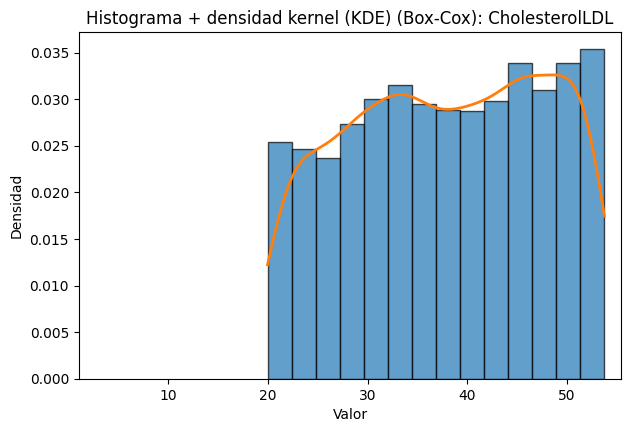

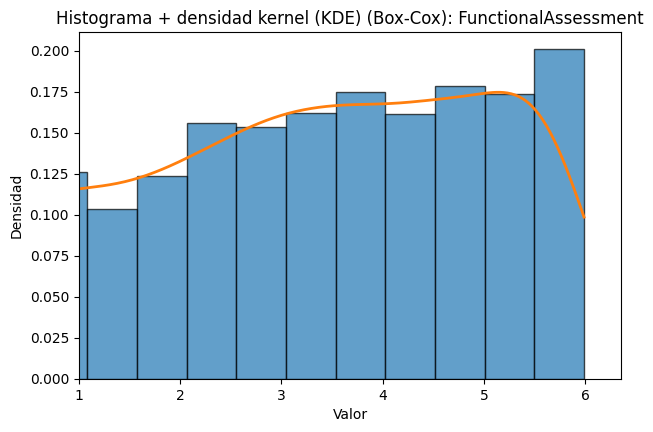

In [11]:
# ===== 1) Histograma + KDE =====
for col in columns_interes:
    columna = df[col].dropna()  # Remove NaNs

    min_val = np.min(columna)
    # Si el valor mínimo es menor o igual a 0, trasladamos los datos
    if min_val <= 0:
      shift_value = abs(min_val) + 1  # Trasladamos los datos para que todos sean positivos
      columna += shift_value
    columna_box_cox, lambda_ = stats.boxcox(columna)
    plt.figure(figsize=(7,4.5))
    plt.hist(columna_box_cox, bins="fd", density=True, alpha=0.7, edgecolor="black")
    plt.xlim(1)
    kde = stats.gaussian_kde(columna_box_cox)
    xs = np.linspace(columna_box_cox.min(), columna_box_cox.max(), 400)
    plt.plot(xs, kde(xs), linewidth=2)
    plt.title(f"Histograma + densidad kernel (KDE) (Box-Cox): {col}")
    plt.xlabel("Valor"); plt.ylabel("Densidad")
    plt.show()
    print("\n")


#### Scatter Plots

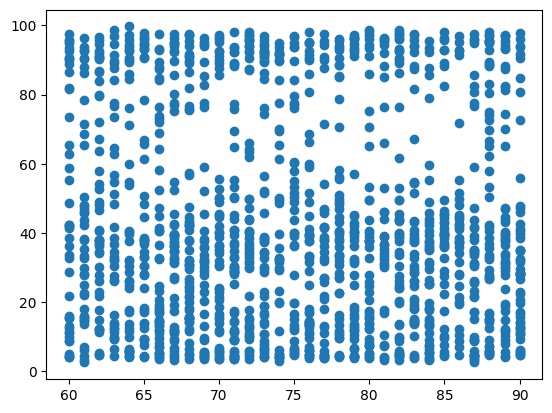

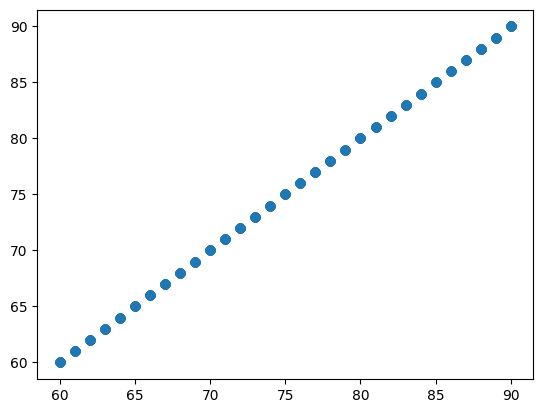

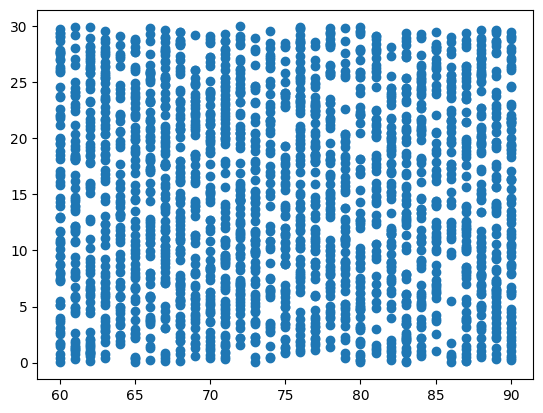

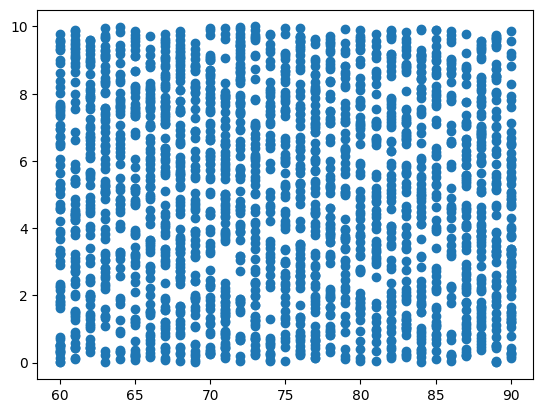

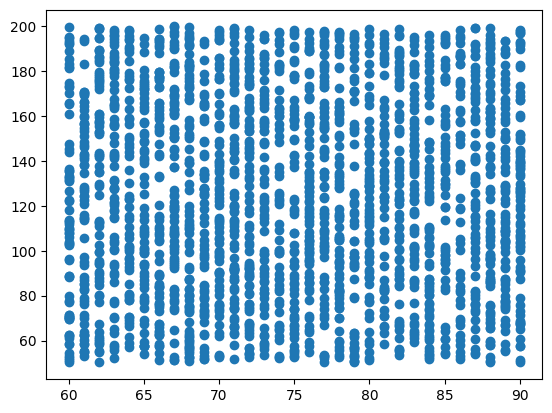

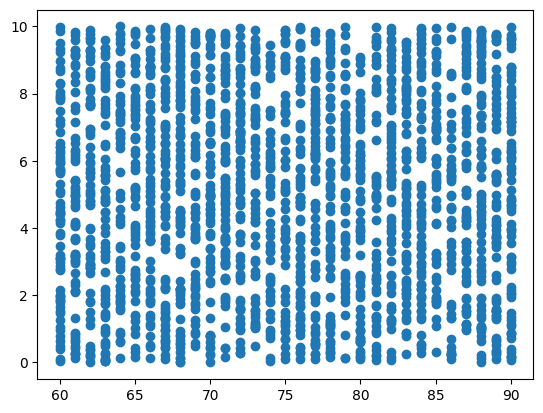

In [ ]:
for c in columns_interes:
    num = df[["Age", c]].dropna()

    plt.scatter(num.iloc[:,0], num.iloc[:,1]); plt.show() 

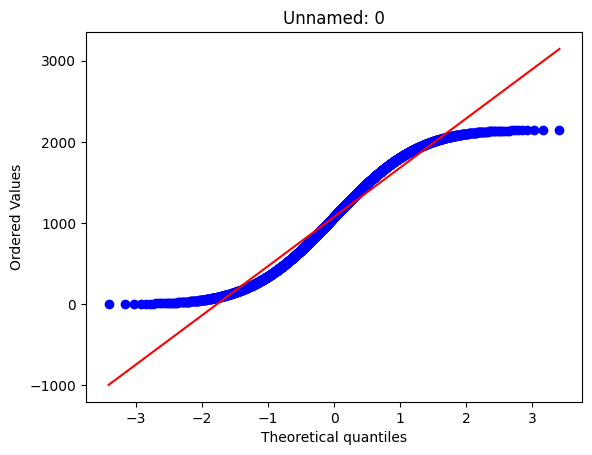

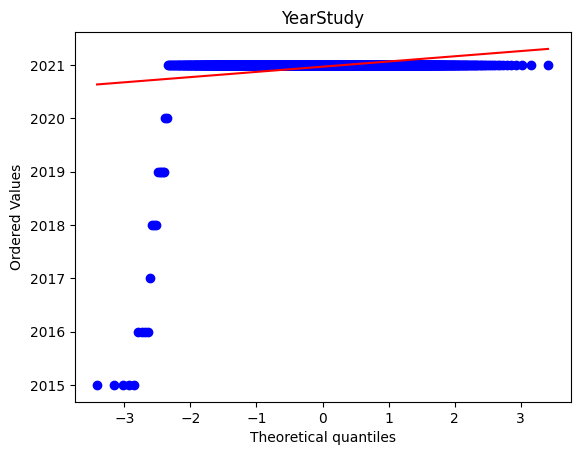

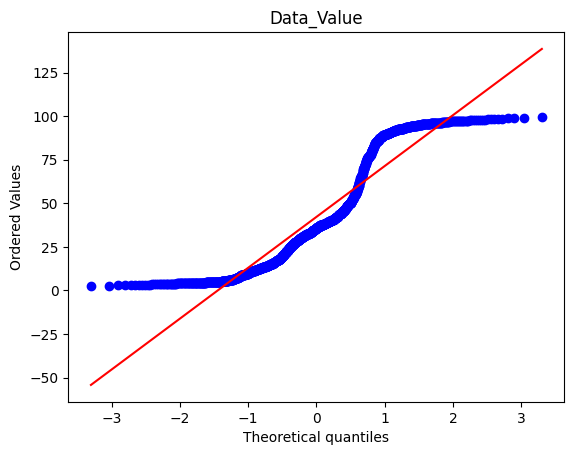

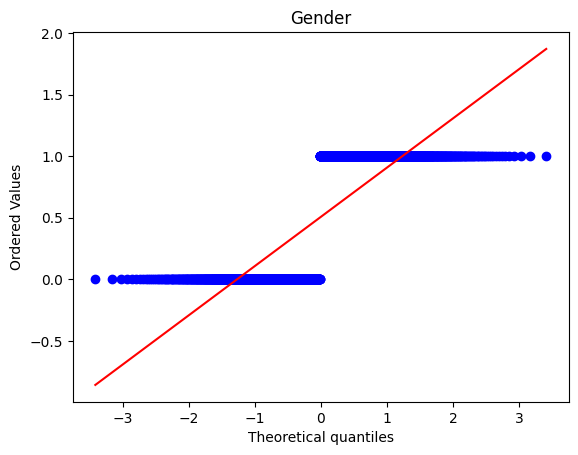

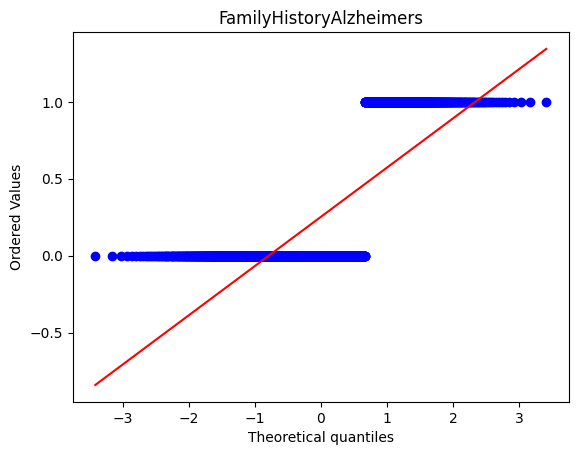

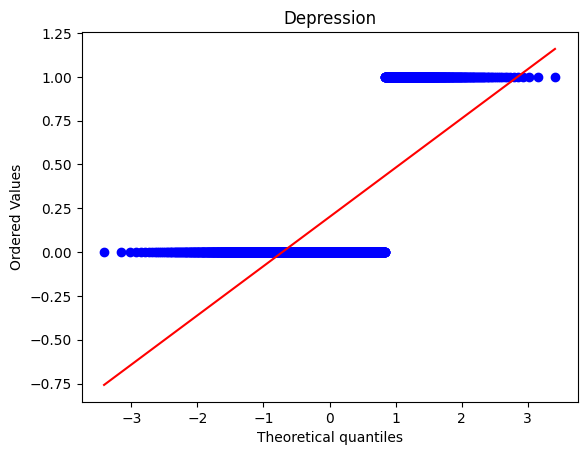

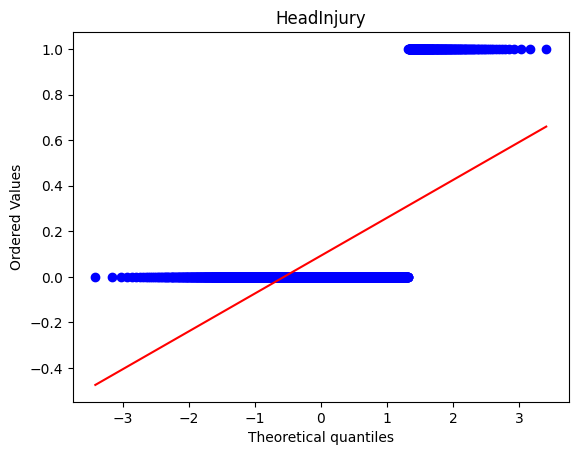

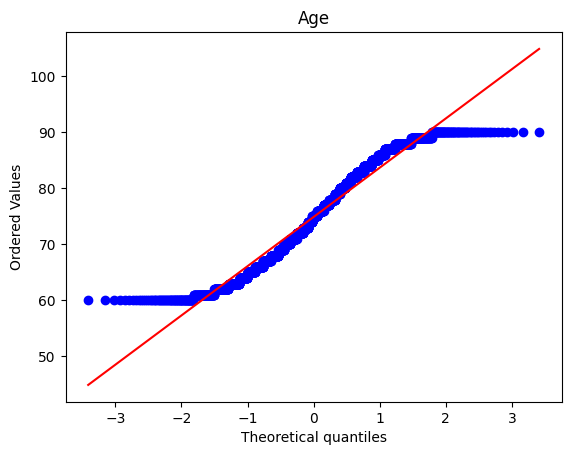

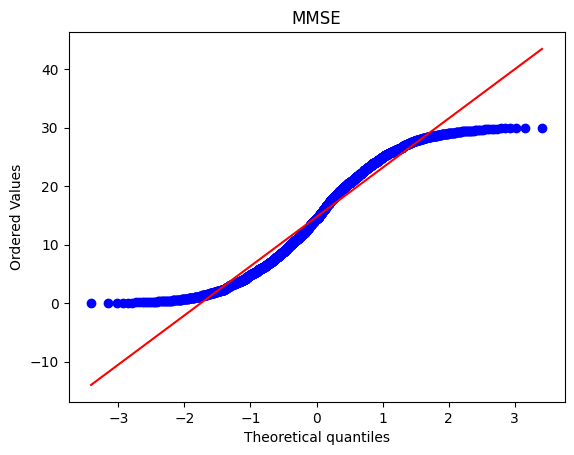

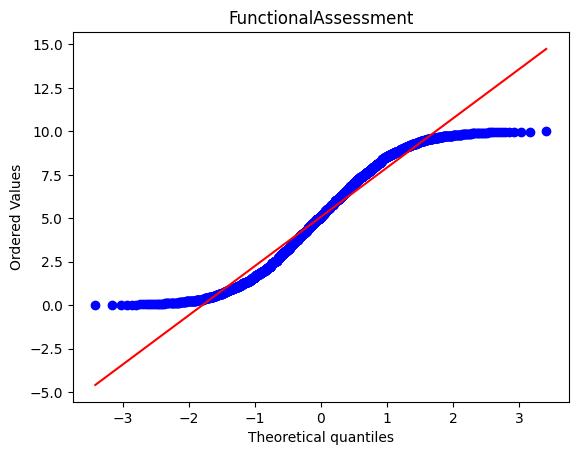

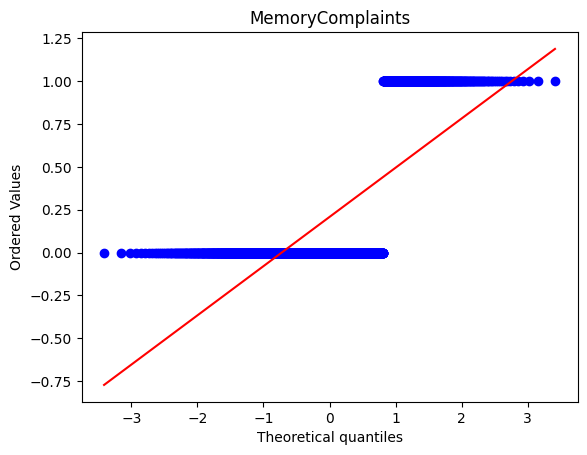

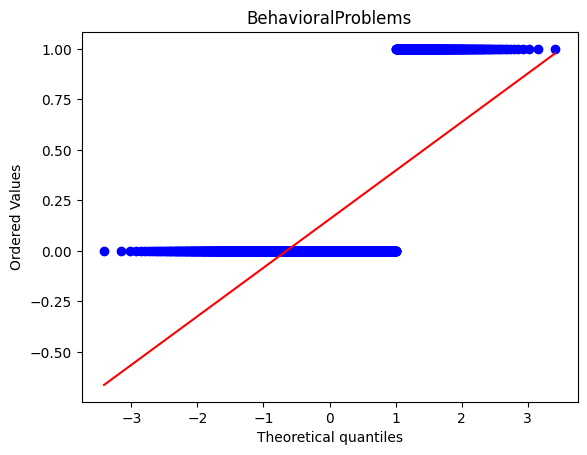

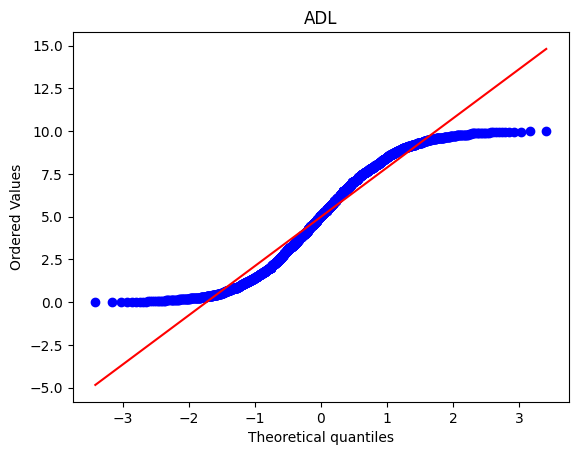

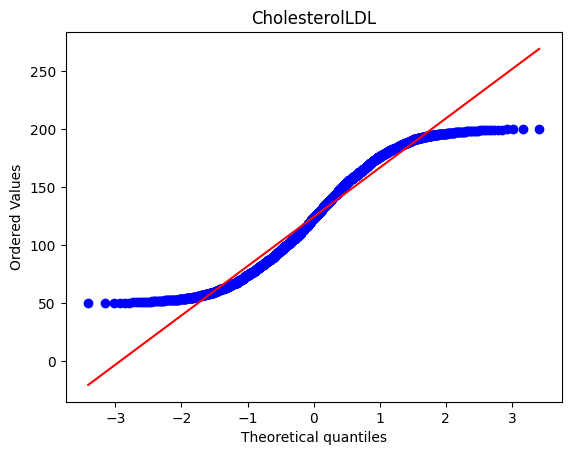

In [ ]:
for col in df.select_dtypes(include="number").columns:
  stats.probplot(df[col].dropna(), dist="norm", plot=plt)
  plt.title(col); plt.show()

## MANOVA

In [23]:
# Eliminar filas con valores nulos en la columna Data_Value
df_cleaned = df.dropna(subset=['Data_Value'])

# Convertir Gender a categoría
df_cleaned['Gender'] = df_cleaned['Gender'].astype('category')

# Fórmula simplificada
formula = "Data_Value + CholesterolLDL ~ C(Age) + C(MMSE) + C(LocationDesc) + C(Gender)"

# Ejecutar el análisis MANOVA
manova = MANOVA.from_formula(formula, data=df_cleaned)
mv_out = manova.mv_test()
print(mv_out)


C:\Users\user\AppData\Local\Temp\ipykernel_11772\1047056348.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Gender'] = df_cleaned['Gender'].astype('category')
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\multivariate\multivariate_ols.py:196: RuntimeWarning: invalid value encountered in power
  lmd = np.power(lmd, 1 / t)


                                 Multivariate linear model
                                                                                            
---------------------------------------------------------------------------------------------
        Intercept                Value         Num DF   Den DF         F Value         Pr > F
---------------------------------------------------------------------------------------------
           Wilks' lambda              -0.0000  2.0000  -85.0000  189896325052817.7500     nan
          Pillai's trace               1.0020  2.0000  -85.0000            20820.5110     nan
  Hotelling-Lawley trace  -4459009532050.9941  2.0000  -42.5000   94753952556083.6250     nan
     Roy's greatest root               0.0020  2.0000  -85.0000               -0.0871     nan
--------------------------------------------------------------------------------------------
                                                                                            
----

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\multivariate\multivariate_ols.py:196: RuntimeWarning: invalid value encountered in power
  lmd = np.power(lmd, 1 / t)
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\multivariate\multivariate_ols.py:196: RuntimeWarning: invalid value encountered in power
  lmd = np.power(lmd, 1 / t)


## ANOVA de una vía

In [24]:
residuos = smf.ols('CholesterolLDL ~ C(Age)*C(MMSE)*C(LocationDesc)*C(Gender)', data=df).fit().resid
print(residuos) #Solamente números

#(Numérica ~ Categóricas multiplicadas entre sí)

MemoryError: Unable to allocate 115. GiB for an array with shape (2149, 7194852) and data type float64

### Age

In [29]:
print(df['Age'].min(), df['Age'].max())

60 90


####

### MMSE

In [26]:
print(df["MMSE"].unique())

[21.46353236 20.61326731  7.35624863 ... 17.0110031   4.03049088
 11.11477737]


### LocationDesc

In [27]:
print(df["LocationDesc"].unique())

['West' 'Northeast' 'Midwest' 'Idaho' 'Louisiana' 'Massachusetts'
 'Maryland' 'New Mexico' 'Ohio' 'Oregon' 'South Carolina' 'South'
 'Wisconsin' 'Tennessee' 'New Hampshire' 'Kansas' 'Utah' 'Rhode Island'
 'Michigan' 'Washington' 'Virginia' 'Arizona' 'Mississippi' 'Montana'
 'West Virginia' 'Missouri' 'Vermont' 'Pennsylvania' 'North Carolina'
 'New Jersey' 'Arkansas' 'Hawaii' 'Connecticut' 'Minnesota' 'Texas'
 'Nebraska' 'New York' 'Maine' 'Alaska' 'Georgia' 'Indiana' 'Kentucky'
 'North Dakota' 'Oklahoma' 'Wyoming' 'District of Columbia' 'Iowa'
 'Alabama' 'South Dakota' 'Illinois' 'Colorado' 'Nevada' 'California'
 'Delaware']


### Gender

In [28]:
print(df["Gender"].unique())

[0 1]
